In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import argparse
import os
import torch
from torch.autograd import Variable
from tqdm import tqdm
import time
from models.deep_isp_model import DenoisingNet
from msr_demosaic import MSRDemosaic
from audio_dataset import AudioDataset, AudioGenDataset
import deep_isp_utils as utils
from collections import OrderedDict
import shutil
import matplotlib.pyplot as plt
from loss import *
from datetime import datetime

import numpy as np
from torch import nn
import quantize
import actquant
import IPython.display as ipd


transformation = utils.JointCompose([
    utils.JointHorizontalFlip(),
    utils.JointVerticalFlip(),
    #utils.JointNormailze(means = [0.485,0.456,0.406],stds = [1,1,1]), #TODO consider use
    utils.JointToTensor(),
])
val_transformation = utils.JointCompose([
    #utils.JointNormailze(means = [0.485,0.456,0.406],stds = [1,1,1]),
    utils.JointToTensor(),
])

Here we put the parameters of the model

In [2]:
num_denoise_layers = 20
quant = False
inject_noise = False
quant_bitwidth = 32
quant_epoch_step = 50
inject_act_noise = False
act_bitwidth = 32
act_quant = False
quant_start_stage = 0
weight_relu = False
weight_grad_after_quant = False
random_inject_noise = False
step = 19
num_workers = 1
wrpn = False

gpus = [0]

The function ```load model``` loads a .tar file from a pretrained model

In [3]:
def load_model(model,checkpoint):

    new_state_dict = OrderedDict()
    for k, v in checkpoint['state_dict'].items():
        name = k[7:] if k[0:6] == 'module.' else k # remove `module. if needed (happen when the model created with DataParallel
        #new_state_dict[name] = v
        new_state_dict[name] = v if v.dim() > 1 or 'num_batches_tracked' in name else v*v.new_ones(1)

    # load params
    model.load_state_dict(new_state_dict, strict=False) #strict false in case the loaded doesn't have alll variables like running mean


In [4]:
model = DenoisingNet(in_channels=1, num_denoise_layers=num_denoise_layers, quant=quant , noise=inject_noise, bitwidth=quant_bitwidth, quant_epoch_step=quant_epoch_step,
                         act_noise=inject_act_noise , act_bitwidth= act_bitwidth , act_quant=act_quant, use_cuda=(gpus is not None), quant_start_stage=quant_start_stage,
                         weight_relu=weight_relu, weight_grad_after_quant=weight_grad_after_quant, random_inject_noise = random_inject_noise
                         , step=step, wrpn=wrpn)
model.cuda()
device = 'cuda:' + str(0)
torch.cuda.set_device(0)

checkpoint_file = "/home/simon/denoise/SavedWeigths/varying_rotor_vol_norpm_1sec_5000_20epoch/checkpoint.pth.tar" # checkpoint location
if os.path.isfile(checkpoint_file):
    print("loading checkpoint {}".format(checkpoint_file))
    checkpoint = torch.load(checkpoint_file, map_location=device)
    load_model(model, checkpoint)
    

/home/simon/denoise/Denoising-drone-rotors/models/deep_isp_model.py:53: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/home/simon/denoise/Denoising-drone-rotors/models/deep_isp_model.py:55: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


loading checkpoint /home/simon/denoise/SavedWeigths/varying_rotor_vol_norpm_1sec_5000_20epoch/checkpoint.pth.tar


In [22]:
# Load dataset

datapath = '/home/simon/denoise/Denoising-drone-rotors/preprocess_audio/data.h5'
# testset = MSRDemosaic(root=datapath, train=False, transform=val_transformation)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)

# use train set to check overfitting
# testset = AudioDataset(data_h5_path=datapath, train=True)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

# trainset = AudioGenDataset("/home/simon/denoise/dataset/generator/")
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=num_workers)
# testset = AudioGenDataset("/home/simon/denoise/dataset/generator/", train=False)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

# with RPM ##########################

trainset = AudioGenDataset("/home/simon/denoise/dataset/mini_dataset/", train=True, dataset_size=50, add_rpm=False)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=num_workers)

# testset = AudioGenDataset("/home/simon/denoise/dataset/generator/", train=False, dataset_size=100, add_rpm=True)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

test_loader = train_loader

# testset = AudioDataset(data_h5_path=datapath, train=False)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)





  0%|          | 0/50 [00:00<?, ?it/s]


  4%|▍         | 2/50 [00:00<00:02, 19.18it/s]

Building dataset





  8%|▊         | 4/50 [00:00<00:02, 19.14it/s]


 12%|█▏        | 6/50 [00:00<00:02, 19.05it/s]


 16%|█▌        | 8/50 [00:00<00:02, 19.05it/s]


 20%|██        | 10/50 [00:00<00:02, 19.05it/s]


 24%|██▍       | 12/50 [00:00<00:02, 18.69it/s]


 28%|██▊       | 14/50 [00:00<00:01, 18.49it/s]


 32%|███▏      | 16/50 [00:00<00:01, 18.33it/s]


 36%|███▌      | 18/50 [00:00<00:01, 18.13it/s]


 40%|████      | 20/50 [00:01<00:01, 18.04it/s]


 44%|████▍     | 22/50 [00:01<00:01, 18.06it/s]


 48%|████▊     | 24/50 [00:01<00:01, 18.07it/s]


 52%|█████▏    | 26/50 [00:01<00:01, 18.05it/s]


 56%|█████▌    | 28/50 [00:01<00:01, 18.10it/s]


 60%|██████    | 30/50 [00:01<00:01, 18.20it/s]


 64%|██████▍   | 32/50 [00:01<00:00, 18.25it/s]


 68%|██████▊   | 34/50 [00:01<00:00, 18.39it/s]


 72%|███████▏  | 36/50 [00:01<00:00, 18.52it/s]


 76%|███████▌  | 38/50 [00:02<00:00, 18.68it/s]


 80%|████████  | 40/50 [00:02<00:00, 18.51it/s]


 84%|████████▍ | 42/50 [00:02<00:00, 18.43it/s]







  0%|          | 0/45 [00:00<?, ?it/s]

data source
data shape: (513, 87)
3.8055153


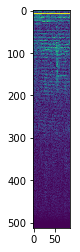

target
max:  4.114165
min:  3.0586943e-07


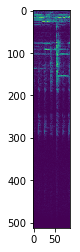

torch.Size([1, 1, 513, 87])
output
4.028875
-0.4039858


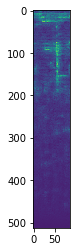




  2%|▏         | 1/45 [00:06<04:35,  6.26s/it]

data source
data shape: (513, 87)
3.7216234


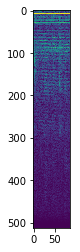

target
max:  3.2937458
min:  7.451608e-07


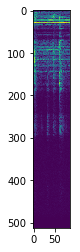

torch.Size([1, 1, 513, 87])
output
3.2665808
-0.54308736


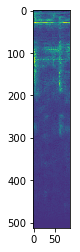




  4%|▍         | 2/45 [00:12<04:29,  6.26s/it]

data source
data shape: (513, 87)
3.677622


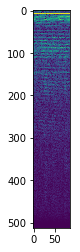

target
max:  3.7335873
min:  8.7973774e-07


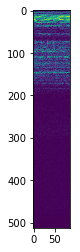

torch.Size([1, 1, 513, 87])
output
3.6988719
-0.19698325


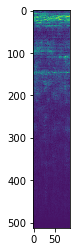




  7%|▋         | 3/45 [00:18<04:23,  6.27s/it]

data source
data shape: (513, 87)
3.3772168


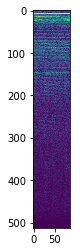

target
max:  3.5752678
min:  7.122281e-06


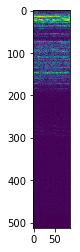

torch.Size([1, 1, 513, 87])
output
3.3848162
-0.3496196


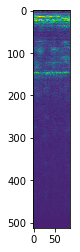




  9%|▉         | 4/45 [00:25<04:16,  6.25s/it]

data source
data shape: (513, 87)
3.4211638


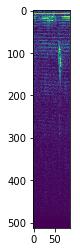

target
max:  4.095437
min:  6.548842e-07


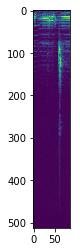

torch.Size([1, 1, 513, 87])
output
4.126962
-0.35472107


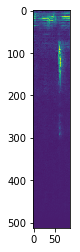




 11%|█         | 5/45 [00:31<04:10,  6.26s/it]

data source
data shape: (513, 87)
3.7148035


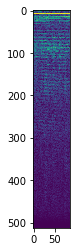

target
max:  4.088619
min:  1.2626101e-06


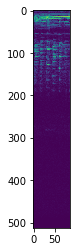

torch.Size([1, 1, 513, 87])
output
3.8977642
-0.51229185


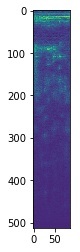




 13%|█▎        | 6/45 [00:37<04:04,  6.27s/it]

data source
data shape: (513, 87)
3.6484065


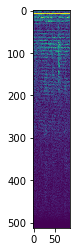

target
max:  3.8739614
min:  6.0019606e-06


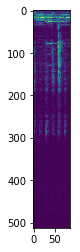

torch.Size([1, 1, 513, 87])
output
3.8929768
-0.47920617


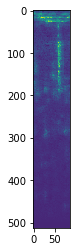




 16%|█▌        | 7/45 [00:43<03:57,  6.26s/it]

data source
data shape: (513, 87)
3.1006594


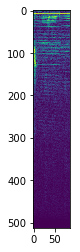

target
max:  3.7924209
min:  4.7286567e-06


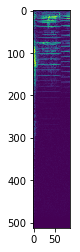

torch.Size([1, 1, 513, 87])
output
3.8823097
-0.18473946


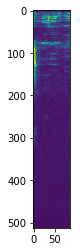




 18%|█▊        | 8/45 [00:50<03:51,  6.25s/it]

data source
data shape: (513, 87)
3.6613362


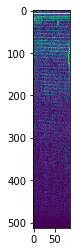

target
max:  3.687878
min:  1.416981e-06


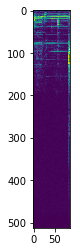

torch.Size([1, 1, 513, 87])
output
3.9359412
-0.41419983


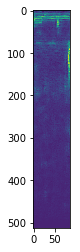




 20%|██        | 9/45 [00:56<03:44,  6.24s/it]

data source
data shape: (513, 87)
3.9435124


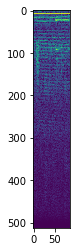

target
max:  4.622039
min:  8.6256654e-07


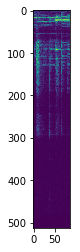

torch.Size([1, 1, 513, 87])
output
4.7274766
-0.35952628


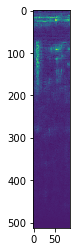




 22%|██▏       | 10/45 [01:02<03:38,  6.24s/it]

data source
data shape: (513, 87)
3.774992


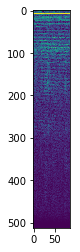

target
max:  3.1000686
min:  1.4082278e-06


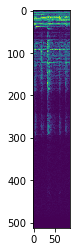

torch.Size([1, 1, 513, 87])
output
3.0994
-0.3729449


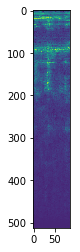




 24%|██▍       | 11/45 [01:08<03:32,  6.24s/it]

data source
data shape: (513, 87)
3.741449


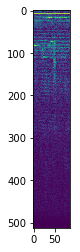

target
max:  4.4368014
min:  1.6017276e-06


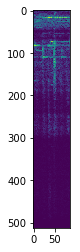

torch.Size([1, 1, 513, 87])
output
4.614758
-0.32734993


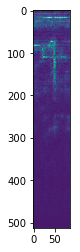




 27%|██▋       | 12/45 [01:15<03:28,  6.32s/it]

data source
data shape: (513, 87)
3.5727398


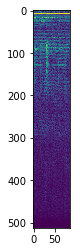

target
max:  4.220581
min:  1.2730701e-06


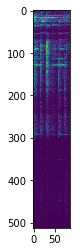

torch.Size([1, 1, 513, 87])
output
4.1218376
-0.647462


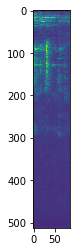




 29%|██▉       | 13/45 [01:21<03:22,  6.32s/it]

data source
data shape: (513, 87)
3.3443058


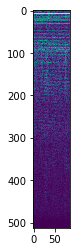

target
max:  3.059253
min:  3.8087571e-06


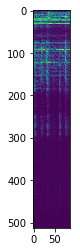

torch.Size([1, 1, 513, 87])
output
3.5233555
-0.3189206


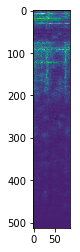




 31%|███       | 14/45 [01:27<03:14,  6.29s/it]

data source
data shape: (513, 87)
3.3893194


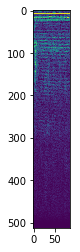

target
max:  4.020746
min:  3.5760202e-06


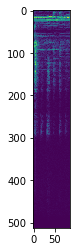

torch.Size([1, 1, 513, 87])
output
3.879725
-0.40325707


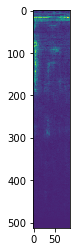




 33%|███▎      | 15/45 [01:33<03:07,  6.26s/it]

data source
data shape: (513, 87)
3.6105688


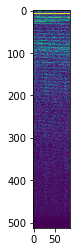

target
max:  4.016032
min:  1.0059068e-06


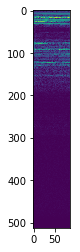

torch.Size([1, 1, 513, 87])
output
3.7800317
-0.37742794


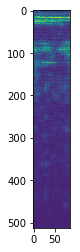




 36%|███▌      | 16/45 [01:40<03:02,  6.29s/it]

data source
data shape: (513, 87)
3.9368043


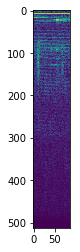

target
max:  4.6600847
min:  3.4613055e-07


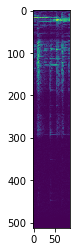

torch.Size([1, 1, 513, 87])
output
4.241292
-0.7376913


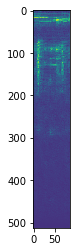




 38%|███▊      | 17/45 [01:46<02:55,  6.28s/it]

data source
data shape: (513, 87)
3.6613693


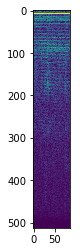

target
max:  3.2021108
min:  2.7064239e-06


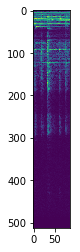

torch.Size([1, 1, 513, 87])
output
3.2566025
-0.2948102


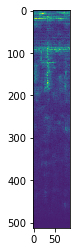




 40%|████      | 18/45 [01:53<02:51,  6.34s/it]

data source
data shape: (513, 87)
3.218398


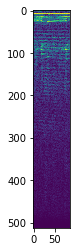

target
max:  3.7184556
min:  1.743722e-06


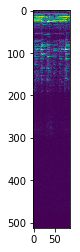

torch.Size([1, 1, 513, 87])
output
3.8325162
-0.29522434


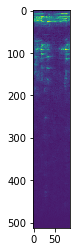




 42%|████▏     | 19/45 [01:59<02:45,  6.35s/it]

data source
data shape: (513, 87)
2.8808715


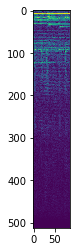

target
max:  3.1809564
min:  1.6692155e-06


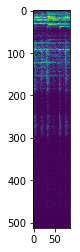

torch.Size([1, 1, 513, 87])
output
2.985505
-0.28422716


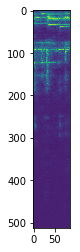




 44%|████▍     | 20/45 [02:05<02:39,  6.37s/it]

data source
data shape: (513, 87)
2.9359088


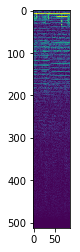

target
max:  3.4434724
min:  1.168696e-06


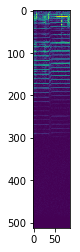

torch.Size([1, 1, 513, 87])
output
3.5762043
-0.27047154


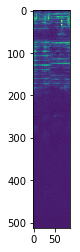




 47%|████▋     | 21/45 [02:12<02:31,  6.32s/it]

data source
data shape: (513, 87)
3.9663012


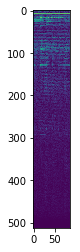

target
max:  4.648264
min:  8.792214e-07


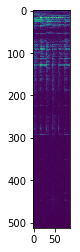

torch.Size([1, 1, 513, 87])
output
4.7359896
-0.33709377


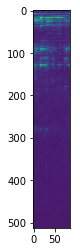




 49%|████▉     | 22/45 [02:18<02:25,  6.31s/it]

data source
data shape: (513, 87)
3.960941


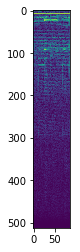

target
max:  4.6294813
min:  9.309903e-08


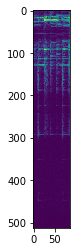

torch.Size([1, 1, 513, 87])
output
4.9895253
-0.5953543


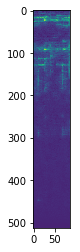




 51%|█████     | 23/45 [02:24<02:17,  6.27s/it]

data source
data shape: (513, 87)
2.8721106


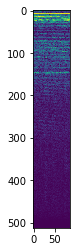

target
max:  3.5752678
min:  7.122281e-06


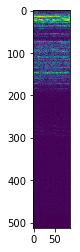

torch.Size([1, 1, 513, 87])
output
3.5377684
-0.21307918


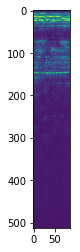




 53%|█████▎    | 24/45 [02:30<02:11,  6.25s/it]

data source
data shape: (513, 87)
3.3841205


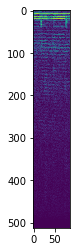

target
max:  4.0482173
min:  1.7352995e-06


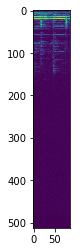

torch.Size([1, 1, 513, 87])
output
4.056447
-0.45306242


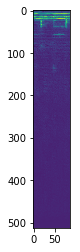




 56%|█████▌    | 25/45 [02:37<02:05,  6.29s/it]

data source
data shape: (513, 87)
2.9941661


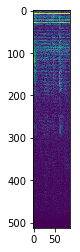

target
max:  3.2937458
min:  7.451608e-07


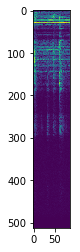

torch.Size([1, 1, 513, 87])
output
2.9523802
-0.23361047


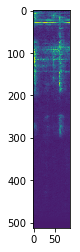




 58%|█████▊    | 26/45 [02:43<01:58,  6.25s/it]

data source
data shape: (513, 87)
2.8488076


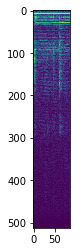

target
max:  3.164358
min:  2.1479182e-06


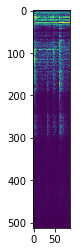

torch.Size([1, 1, 513, 87])
output
3.2108374
-0.23196633


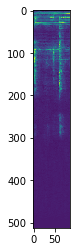




 60%|██████    | 27/45 [02:49<01:53,  6.28s/it]

data source
data shape: (513, 87)
4.005245


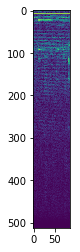

target
max:  4.6180625
min:  4.445168e-06


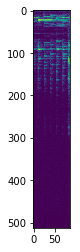

torch.Size([1, 1, 513, 87])
output
4.682078
-0.647149


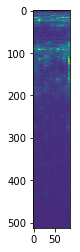




 62%|██████▏   | 28/45 [02:55<01:46,  6.29s/it]

data source
data shape: (513, 87)
3.7524366


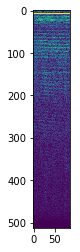

target
max:  3.508852
min:  8.865419e-07


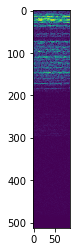

torch.Size([1, 1, 513, 87])
output
3.6141472
-0.33330908


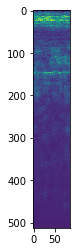




 64%|██████▍   | 29/45 [03:02<01:40,  6.28s/it]

data source
data shape: (513, 87)
3.5043352


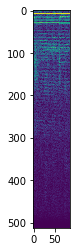

target
max:  3.4335482
min:  4.491275e-07


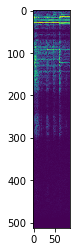

torch.Size([1, 1, 513, 87])
output
3.1724553
-0.46191028


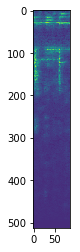




 67%|██████▋   | 30/45 [03:08<01:33,  6.26s/it]

data source
data shape: (513, 87)
3.1905022


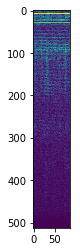

target
max:  3.460954
min:  1.2872565e-06


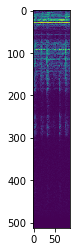

torch.Size([1, 1, 513, 87])
output
3.395473
-0.44308537


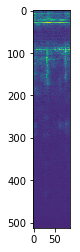




 69%|██████▉   | 31/45 [03:14<01:27,  6.25s/it]

data source
data shape: (513, 87)
3.4832664


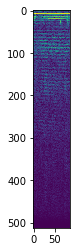

target
max:  3.9096427
min:  2.0008532e-07


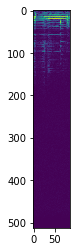

torch.Size([1, 1, 513, 87])
output
3.636939
-0.3897052


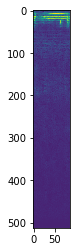




 71%|███████   | 32/45 [03:20<01:21,  6.24s/it]

data source
data shape: (513, 87)
3.3243067


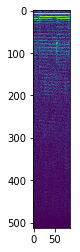

target
max:  4.0101786
min:  8.8754456e-07


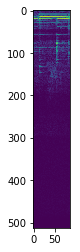

torch.Size([1, 1, 513, 87])
output
4.140774
-0.34574115


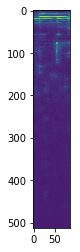




 73%|███████▎  | 33/45 [03:26<01:14,  6.18s/it]

data source
data shape: (513, 87)
3.1124837


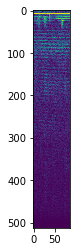

target
max:  3.5973015
min:  6.317524e-07


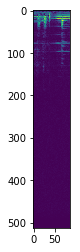

torch.Size([1, 1, 513, 87])
output
3.6834154
-0.62761784


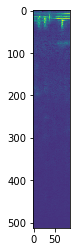




 76%|███████▌  | 34/45 [03:33<01:08,  6.20s/it]

data source
data shape: (513, 87)
3.7451699


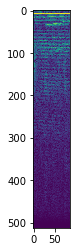

target
max:  3.722677
min:  3.8682273e-07


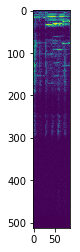

In [ ]:
import IPython.display as ipd
from preprocess_audio.preprocess_audio import *
# convert back to audio
from preprocess_audio.postprocess_audio import *


# ipd.Audio('/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav')
# ipd.Audio(x, rate=sr) # load a NumPy array

def unbias_image(img):
    return  torch.clamp(img, 0 , 1.).data.squeeze(0).cpu().numpy()#.transpose(1, 2, 0) + 0.5  #the clamp is becuase the value should be between 0-1


# Run inference
loader = test_loader
N_CHANNELS = 513
N_FFT = 1024
fs = 22050
n = 5

# create_spectogram
# def read_audio_spectum(filename):
#     x, fs = librosa.load(filename)
#     S = librosa.stft(x, N_FFT)
#     p = np.angle(S)
#     return np.log1p(np.abs(S[np.newaxis,:,:1000])), fs

# a_content, fs = read_audio_spectum("/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav")
# N_SAMPLES = a_content.shape[2]
# N_CHANNELS = a_content.shape[1]
# # a_style = a_style[:, :N_CHANNELS, :N_SAMPLES]

# t = np.zeros_like(a_content)
# a = np.zeros_like(a_content[0])
# a[:N_CHANNELS,:] = np.exp(t[0]) - 1

# # This code is supposed to do phase reconstruction
# p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
# for i in range(500):
#     S = a * np.exp(1j*p)
#     x = librosa.istft(S)
#     p = np.angle(librosa.stft(x, N_FFT))

# librosa.output.write_wav("/home/simon/denoise/dataset/audio/file_example_WAV_1MG_re.wav", x, fs)
# ipd.Audio(x, rate=fs) # load a NumPy array
def to_image(data):
    img = data.data.cpu().squeeze(0).squeeze(0).numpy()
    return img
    if img.shape[0] == 2:
        img = img[0,:,:]
#     img = np.clip(img, 0 , 5.0)
#     img = abs(img)
    return img

for batch_idx, (data, target, fname) in enumerate(tqdm(loader)):
    # infer noisy sample
    if gpus is not None:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)

    with torch.no_grad():
        data, target = Variable(data), Variable(target)
    # display noisy sample
    
    plt.figure()
    print("data source")
    data_image = to_image(data)
    print("data shape:", data_image.shape)
    print(data_image.max())
    plt.imshow(data_image, interpolation='nearest')
    plt.show()
    y = spectogram_to_wav(data_image, N_CHANNELS, N_FFT, fs, dst_path='/home/simon/denoise/dataset/data/orig_{}.wav'.format(batch_idx))
    ipd.display(ipd.Audio(y, rate=fs)) # load a NumPy array
    
    # display target sample
    print("target")
    target_image = to_image(target)
    print("max: ", target_image.max())
    print("min: ", target_image.min())
    plt.imshow(target_image, interpolation='nearest')
    plt.show()
    t = spectogram_to_wav(target_image, N_CHANNELS, N_FFT, fs, dst_path='/home/simon/denoise/dataset/data/target_{}.wav'.format(batch_idx))
    ipd.display(ipd.Audio(t, rate=fs)) # load a NumPy array


        
    print(data.shape)
#     print("rpm: ", data[0,1,0,0])
    output = model(data)
#     np_output = unbias_image(output).squeeze(0)*data_image.max()
    np_output = to_image(output)
#     np_output = np.clip(np_output, 0 ,40.0)
#     np_output = np_output.max()

    # display infered sample
    print("output")
    print(np_output.max())
    print(np_output.min())
#     np_output = np.clip(np_output)
    plt.imshow(np_output, interpolation='nearest')
    plt.show()
    dst_file_path = '/home/simon/denoise/dataset/data/test_{}.wav'.format(batch_idx)
    x = spectogram_to_wav(np_output, N_CHANNELS, N_FFT, fs, dst_path=dst_file_path)
    ipd.display(ipd.Audio(x, rate=fs))


In [ ]:
# ipd.Audio(x, rate=fs) # load a NumPy array
ipd.Audio(y, rate=fs) # load a NumPy array

In [ ]:
audio_sample_file_path = '/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav'
ipd.Audio(audio_sample_file_path) # load a local WAV file

# convert to spectogram
N_FFT = 1024
sound_audio, fs = librosa.load(audio_sample_file_path)
spectogram_sound_label, N_CHANNELS = create_spectogram(sound_audio, N_FFT)
print("from create_spectogram shape: ", spectogram_sound_label.shape)

# convert back to audio
from preprocess_audio.postprocess_audio import *


# hf = h5py.File('/home/simon/denoise/dataset/data/data.h5', 'r')
# train = hf.get('train')
# input = train.get('input')
# train_input_list = list(input.keys())
# # print(train_input_list)
# specto = np.array(input.get(train_input_list[0]))
# print("specto shape: ", specto.shape)
# x = spectogram_to_wav(specto, 513, 1024, 22050)
# print(x.shape)
# hf.close()

x = spectogram_to_wav(spectogram_sound_label, N_CHANNELS, N_FFT, fs)
ipd.Audio(x, rate=fs) # load a local WAV file
